In [4]:
import scipy.io as sio
import torch
from unet import UNet
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# --------------------
# Device
# --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------
# Load training data
# --------------------
train_X = sio.loadmat("data/train/X.mat")["X"]  # (200, 90, 30)
train_Y = sio.loadmat("data/train/Y.mat")["Y"]

# --------------------
# Min-Max normalization
# --------------------
X_min, X_max = train_X.min(), train_X.max()
Y_min, Y_max = train_Y.min(), train_Y.max()

train_X_norm = (train_X - X_min) / (X_max - X_min)
train_Y_norm = (train_Y - Y_min) / (Y_max - Y_min)

# Convert to torch tensors and add channel dimension
train_X_tensor = torch.tensor(train_X_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor = torch.tensor(train_Y_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor.shape

torch.Size([200, 1, 30, 90])

In [6]:
# --------------------
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, out_channels, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.act = nn.ReLU()

    def forward(self, x):
        x1 = self.pool(self.act(self.conv1(x)))  # Downsample
        x2 = self.pool(self.act(self.conv2(x1))) # Downsample
        x3 = self.up(self.act(self.conv3(x2)))   # Upsample
        x4 = self.up(self.act(self.conv4(x3)))   # Output same shape as input
        return x4

In [4]:
def train_model(model_name, model_class, epochs, learning_rate, kf, k_folds):
    print(f"\n### Training {model_name} ###")

    all_train_losses, all_val_losses = [], []
    best_val_loss_overall = float('inf')
    best_model_state_overall = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
        print(f"\n===== Fold {fold + 1}/{k_folds} =====")

        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

        model = model_class().to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses, val_losses = [], []
        best_val_loss = float('inf')

        for epoch in range(epochs):
            # --- Training ---
            model.train()
            running_loss = 0.0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # --- Validation ---
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred_val = model(x_val)
                    val_loss += criterion(y_pred_val, y_val).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            if (epoch + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Train: {avg_train_loss:.6f}, Val: {avg_val_loss:.6f}")

            # Update best model across folds
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                if avg_val_loss < best_val_loss_overall:
                    best_val_loss_overall = avg_val_loss
                    best_model_state_overall = model.state_dict()

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

    # Save the overall best model once
    if best_model_state_overall is not None:
        model_path = f"{model_name.lower()}_best_model.pth"
        torch.save(best_model_state_overall, model_path)
        print(f"\nSaved overall best {model_name} model with val loss {best_val_loss_overall:.6f}")

    return all_train_losses, all_val_losses, model_path, best_val_loss_overall


In [5]:
def grid_search_learning_rate(model_name, model_class, epochs, learning_rates, kf, k_folds):
    print(f"\n### Grid Search for {model_name} Learning Rate ###")

    best_lr = None
    best_val_loss_overall = float('inf')
    best_model_path = None
    lr_results = {}

    for lr in learning_rates:
        print(f"\n--- Testing learning rate: {lr} ---")
        all_train_losses, all_val_losses, model_path_for_lr, val_loss_for_lr = train_model(
            model_name, model_class, epochs, lr, kf, k_folds
        )

        lr_results[lr] = val_loss_for_lr

        # Update best learning rate if current is better
        if val_loss_for_lr < best_val_loss_overall:
            best_val_loss_overall = val_loss_for_lr
            best_lr = lr
            best_model_path = model_path_for_lr

    print(f"\nBest learning rate for {model_name}: {best_lr} with val loss {best_val_loss_overall:.6f}")
    return best_lr, best_model_path, lr_results


In [6]:
# --------------------
# Pad training data
# --------------------
num_encoding_blocks = 3
divisor = 2 ** num_encoding_blocks

pad_h = (divisor - train_X_tensor.shape[2] % divisor) % divisor
pad_w = (divisor - train_X_tensor.shape[3] % divisor) % divisor

train_X_tensor = F.pad(train_X_tensor, (0, pad_w, 0, pad_h))
train_Y_tensor = F.pad(train_Y_tensor, (0, pad_w, 0, pad_h))
print("Padded train shapes:", train_X_tensor.shape, train_Y_tensor.shape)

# --------------------
# Dataset and CV setup
# --------------------
full_dataset = TensorDataset(train_X_tensor, train_Y_tensor)


Padded train shapes: torch.Size([200, 1, 32, 96]) torch.Size([200, 1, 32, 96])


In [7]:
from sklearn.model_selection import KFold

k_folds = 3  # you can adjust
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

learning_rates = [1e-5, 2e-5, 1e-4]
epochs = 50
# U-Net grid search
best_unet_lr, unet_model_path, unet_lr_results = grid_search_learning_rate(
    "U-Net",
    lambda: UNet(
        dimensions=2,
        in_channels=1,
        out_classes=1,
        num_encoding_blocks=num_encoding_blocks,
        normalization='batch',
        activation='ReLU',
        padding=1),
    epochs,
    learning_rates,
    kf,
    k_folds
)

# CNN grid search
best_cnn_lr, cnn_model_path, cnn_lr_results = grid_search_learning_rate(
    "CNN",
    SimpleCNN,
    epochs,
    learning_rates,
    kf,
    k_folds
)



### Grid Search for U-Net Learning Rate ###

--- Testing learning rate: 1e-05 ---

### Training U-Net ###

===== Fold 1/5 =====
Epoch [50/60] - Train: 0.069476, Val: 0.068001

===== Fold 2/5 =====
Epoch [50/60] - Train: 0.069246, Val: 0.064407

===== Fold 3/5 =====
Epoch [50/60] - Train: 0.066687, Val: 0.075197

===== Fold 4/5 =====
Epoch [50/60] - Train: 0.068250, Val: 0.064453

===== Fold 5/5 =====
Epoch [50/60] - Train: 0.065192, Val: 0.075007

Saved overall best U-Net model with val loss 0.062955

--- Testing learning rate: 2e-05 ---

### Training U-Net ###

===== Fold 1/5 =====
Epoch [50/60] - Train: 0.064250, Val: 0.061978

===== Fold 2/5 =====
Epoch [50/60] - Train: 0.064896, Val: 0.061317

===== Fold 3/5 =====
Epoch [50/60] - Train: 0.060897, Val: 0.070169

===== Fold 4/5 =====
Epoch [50/60] - Train: 0.063186, Val: 0.060745

===== Fold 5/5 =====
Epoch [50/60] - Train: 0.063534, Val: 0.073193

Saved overall best U-Net model with val loss 0.058745

--- Testing learning rate: 0.0

In [8]:
epochs = 1000
k_folds = 5  # you can adjust
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# Train U-Net with best learning rate
unet_train, unet_val, unet_model_path_final, unet_val_loss_final = train_model(
    "U-Net",
    lambda: UNet(
        dimensions=2,
        in_channels=1,
        out_classes=1,
        num_encoding_blocks=num_encoding_blocks,
        normalization='batch',
        activation='ReLU',
        padding=1),
    epochs=epochs,
    learning_rate=best_unet_lr,
    kf=kf,
    k_folds=k_folds
)

# Train CNN with best learning rate
cnn_train, cnn_val, cnn_model_path_final, cnn_val_loss_final = train_model(
    "CNN",
    SimpleCNN,
    epochs=epochs,
    learning_rate=best_cnn_lr,
    kf=kf,
    k_folds=k_folds
)



### Training U-Net ###

===== Fold 1/5 =====
Epoch [50/1000] - Train: 0.059721, Val: 0.057837
Epoch [100/1000] - Train: 0.055669, Val: 0.055609
Epoch [150/1000] - Train: 0.053522, Val: 0.054615
Epoch [200/1000] - Train: 0.053287, Val: 0.053704
Epoch [250/1000] - Train: 0.051409, Val: 0.054368
Epoch [300/1000] - Train: 0.049950, Val: 0.053043
Epoch [350/1000] - Train: 0.048163, Val: 0.056093
Epoch [400/1000] - Train: 0.047264, Val: 0.050672
Epoch [450/1000] - Train: 0.044990, Val: 0.058143
Epoch [500/1000] - Train: 0.043956, Val: 0.049192
Epoch [550/1000] - Train: 0.042404, Val: 0.049645
Epoch [600/1000] - Train: 0.041559, Val: 0.051094
Epoch [650/1000] - Train: 0.039589, Val: 0.049201
Epoch [700/1000] - Train: 0.038113, Val: 0.047006
Epoch [750/1000] - Train: 0.039544, Val: 0.059888
Epoch [800/1000] - Train: 0.038019, Val: 0.052193
Epoch [850/1000] - Train: 0.035043, Val: 0.044994
Epoch [900/1000] - Train: 0.036311, Val: 0.047338
Epoch [950/1000] - Train: 0.035071, Val: 0.043671
Epoch

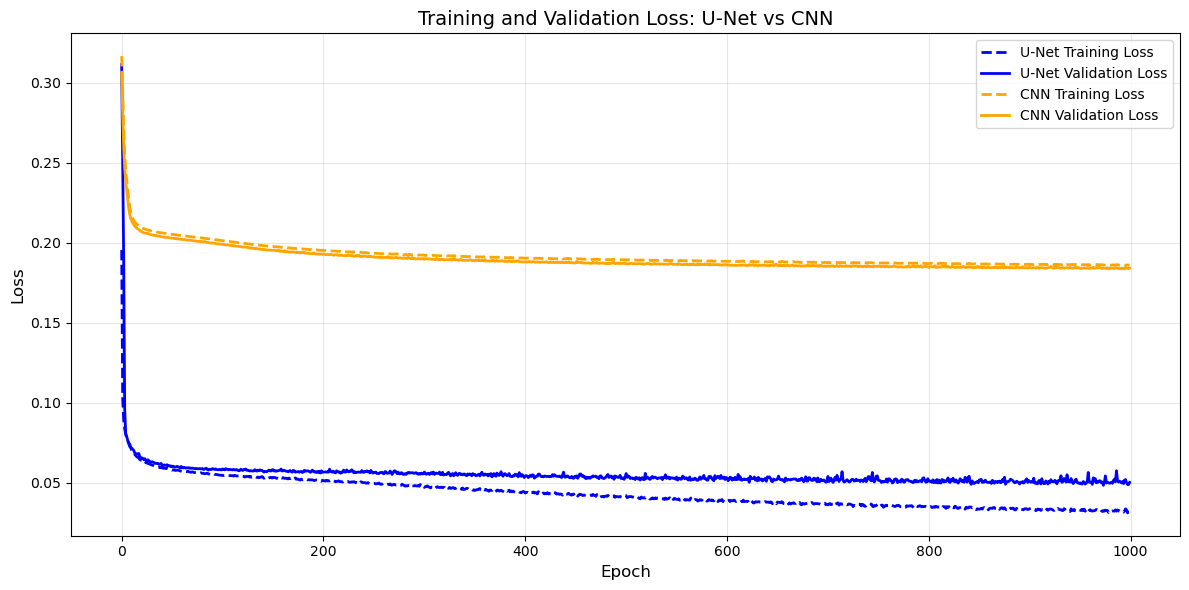

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Convert to numpy arrays and average across folds
# --------------------
unet_train_mean = np.mean(np.array(unet_train), axis=0)
unet_val_mean   = np.mean(np.array(unet_val), axis=0)

cnn_train_mean  = np.mean(np.array(cnn_train), axis=0)
cnn_val_mean    = np.mean(np.array(cnn_val), axis=0)

# --------------------
# Plot training & validation loss
# --------------------
plt.figure(figsize=(12, 6))

# U-Net
plt.plot(unet_train_mean, label='U-Net Training Loss', linestyle='--', color='blue', linewidth=2)
plt.plot(unet_val_mean,   label='U-Net Validation Loss', linestyle='-', color='blue', linewidth=2)

# CNN
plt.plot(cnn_train_mean, label='CNN Training Loss', linestyle='--', color='orange', linewidth=2)
plt.plot(cnn_val_mean,   label='CNN Validation Loss', linestyle='-', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss: U-Net vs CNN', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
# --------------------
# Load validation data
# --------------------
val_X = sio.loadmat("data/val/X.mat")["X"]
val_Y = sio.loadmat("data/val/Y.mat")["Y"]

# Normalize using training min/max
val_X_norm = (val_X - X_min) / (X_max - X_min)
val_Y_norm = (val_Y - Y_min) / (Y_max - Y_min)

val_X_tensor = torch.tensor(val_X_norm, dtype=torch.float32).unsqueeze(1)
val_Y_tensor = torch.tensor(val_Y_norm, dtype=torch.float32).unsqueeze(1)

# Pad validation tensors same way as training
val_X_tensor = F.pad(val_X_tensor, (0, pad_w, 0, pad_h))
val_Y_tensor = F.pad(val_Y_tensor, (0, pad_w, 0, pad_h))

# --------------------
# Validation / prediction
# --------------------
# U-Net
unet_model = UNet(
    dimensions=2,
    in_channels=1,
    out_classes=1,
    num_encoding_blocks=num_encoding_blocks,
    normalization='batch',
    activation='ReLU',
    padding=1
).to(device)

unet_model.load_state_dict(torch.load(unet_model_path, map_location=device))
unet_model.eval()

# CNN
cnn_model = SimpleCNN(in_channels=1, out_channels=1).to(device)
cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=device))
cnn_model.eval()


# --------------------
# Make predictions
# --------------------
with torch.no_grad():
    val_pred_unet = unet_model(val_X_tensor)
    val_pred_cnn  = cnn_model(val_X_tensor)

# --------------------
# Unnormalize predictions and ground truth
# --------------------
val_true_denorm       = val_Y_tensor.cpu().numpy() * (Y_max - Y_min) + Y_min
val_pred_unet_denorm  = val_pred_unet.cpu().numpy() * (Y_max - Y_min) + Y_min
val_pred_cnn_denorm   = val_pred_cnn.cpu().numpy()  * (Y_max - Y_min) + Y_min

# Remove padding for plotting (if needed)
val_true_denorm = val_true_denorm[:, :, :val_Y.shape[1], :val_Y.shape[2]]
val_pred_unet_denorm = val_pred_unet_denorm[:, :, :val_Y.shape[1], :val_Y.shape[2]]
val_pred_cnn_denorm  = val_pred_cnn_denorm[:, :, :val_Y.shape[1], :val_Y.shape[2]]




/tmp/ipykernel_10704/2348573049.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(unet_model_path, map_location=device))
/tmp/ipyker

/tmp/ipykernel_10704/3540373436.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


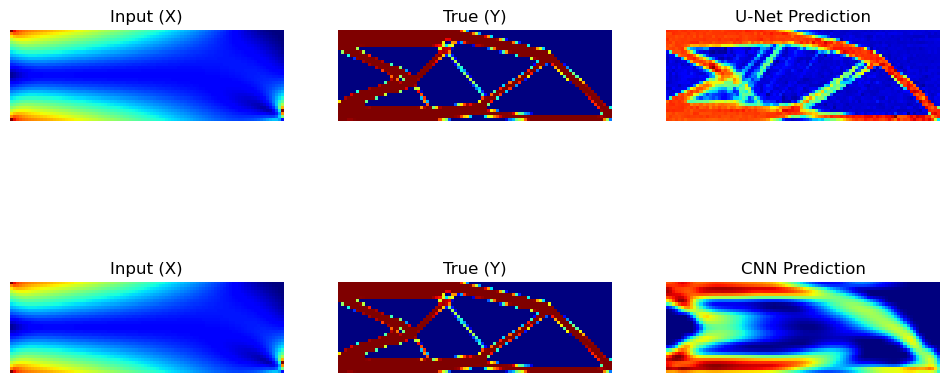

In [11]:
# --------------------
# Visualization example (first sample)
# --------------------
idx = 0  # index of sample to visualize
fig, axes = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

# ----- Row 1: U-Net -----
axes[0,0].imshow(val_X[idx, :, :], cmap="jet")
axes[0,0].set_title("Input (X)")
axes[0,0].axis("off")

axes[0,1].imshow(val_true_denorm[idx, 0, :, :], cmap="jet")
axes[0,1].set_title("True (Y)")
axes[0,1].axis("off")

axes[0,2].imshow(val_pred_unet_denorm[idx, 0, :, :], cmap="jet")
axes[0,2].set_title("U-Net Prediction")
axes[0,2].axis("off")

# ----- Row 2: CNN -----
axes[1,0].imshow(val_X[idx, :, :], cmap="jet")
axes[1,0].set_title("Input (X)")
axes[1,0].axis("off")

axes[1,1].imshow(val_true_denorm[idx, 0, :, :], cmap="jet")
axes[1,1].set_title("True (Y)")
axes[1,1].axis("off")

axes[1,2].imshow(val_pred_cnn_denorm[idx, 0, :, :], cmap="jet")
axes[1,2].set_title("CNN Prediction")
axes[1,2].axis("off")

plt.tight_layout()
plt.show()